## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query("converted == 1").converted.count() / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#solution1:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [7]:
#solution2:
df.query('group == "treatment" & landing_page != "new_page"').user_id.count() + df.query('group != "treatment" & landing_page == "new_page"').user_id.count()

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df_drop = df.query('(group == "treatment" & landing_page == "old_page") or (group == "control" & landing_page == "new_page")').index
df2 = df.drop(df_drop)


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
len(df2)

290585

In [13]:
df2[df2.duplicated('user_id')].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
repeat_id = df2[df2.duplicated('user_id')].user_id
df2[df2.user_id == int(repeat_id)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(1899, inplace = True)
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_convert_prob = df2.query('group == "control"').converted.mean()
control_convert_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_convert_prob = df2.query('group == "treatment"').converted.mean()
treatment_convert_prob

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
ttl = len(df2)
new_page_count = df2[df2['landing_page'] == 'new_page'].user_id.count()
new_page_prob = new_page_count / ttl
new_page_prob 

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

<font color=#00008B face = '黑體'>
Given the above consquences, the probabilities of conversions regardless of the received page is 11.96%. The probabilities of conversions of control page and treatment page are 12.04% and 11.88%, respectively. The probabilities of control group is slighly higher than that of treatment group, yet two values are pretty close to each other. As a result, there is no sufficient evidence to conclude that new page leads to more conversions than old one.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is **do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?**  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<center>
<font size= 2 color=#00008B face = '黑體'>
$H0$: $p_{new}$  - $p_{old}$  $<=$ $0$

<center><br>
$H1$: $p_{new}$  - $p_{old}$   $>$ $0$
  
</center>



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

*Note: 
Assume under the null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate regardless of page - that is  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  are equal.*

In [20]:
P_new = df2.converted.mean()
P_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
P_old = df2.converted.mean()
P_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
new_num = df2.query('landing_page == "new_page"').user_id.count()
new_num 

145310

d. What is $n_{old}$?

In [23]:
old_num = df2.query('landing_page == "old_page"').user_id.count()
old_num 

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = \
    np.random.choice([0,1], size = new_num, p = [(1- P_new), P_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = \
    np.random.choice([0,1], size = old_num, p = [(1- P_old), P_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00189068017163814

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [27]:
#way1:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):
    bootstrap = df2.sample(size, replace = True)
    new_page_converted = np.random.choice([0,1], size = new_num, p = [(1- P_new), P_new])
    old_page_converted = np.random.choice([0,1], size = old_num, p = [(1- P_old), P_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs = np.array(p_diffs)

In [28]:
p_diffs = pd.DataFrame(p_diffs)
p_diffs.head()

,0
0,0.002400
1,0.000542
2,-0.001716
3,0.001305
4,-0.001069


In [29]:
#way2:
new_mean_simulation = np.random.binomial(new_num, P_new, 10000) / new_num
old_mean_simulation = np.random.binomial(old_num, P_old, 10000) / old_num
p_diffs_2 = new_mean_simulation - old_mean_simulation
p_diffs_2 = pd.DataFrame(p_diffs_2)
p_diffs_2.head()

,0
0,-0.001950
1,-0.000677
2,0.000686
3,-0.000112
4,-0.000580


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

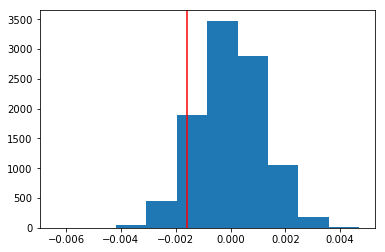

In [36]:
#way1:
obs_diff = treatment_convert_prob - control_convert_prob

plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = 'red');

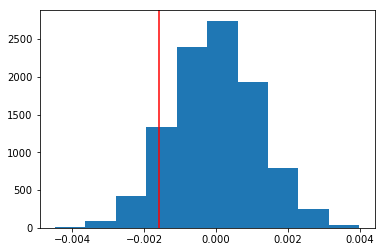

In [31]:
#way2:
obs_diff = treatment_convert_prob - control_convert_prob

plt.hist(p_diffs_2)
plt.axvline(x = obs_diff, color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(p_diffs > obs_diff).mean()

0    0.9045
dtype: float64

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<font color=#00008B face = '黑體'>
    The value of we got in part j is called "p-value", which is 0.903, given the above consequence. P-value means that the probability of finding the observed, or more extreme, if the null hypothesis is true. P-value here (0.903) is far larger than Type I error rate of 0.05, so there is no statistically significant between new page and old page, that is, it fails to reject the null hypothesis. In conclusion, it is better for the company to remain the current page (the old page), so it is more likely to convert more individuals on the page.



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [37]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').converted.size
n_new = df2.query('group == "treatment"').converted.size

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [44]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

In [49]:
from scipy.stats import norm

norm.cdf(z_score), norm.ppf(1-(0.05/2))
# 1:Tells us how significant our z-score is
# 2:Tells us what our critical value at 95% confidence is

(0.094941687240975514, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<font color=#00008B face = '黑體'>
Based on the hypothesis, it is a one-tail test and hence, a z-score past 1.96 (95% confidence level) is significant. <br>
Given the above data, the z-score is about 1.31 and doesn't past 1.96, so, it is not significant. Also, its p-value is 0.905, close to the p-value got from part j. It is larger than 0.05. Therefore, it fails to reject the null hypothesis and it means that there is no difference of the conversion rate between control group and treatment group, corresponding to the result in part j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color=#00008B face = '黑體'>
Logistic Regession
    <br>(It is because that the response variable is categorical variable.)

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [50]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [52]:
df2['intercept'] = 1

df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('control', axis = 1, inplace = True)

In [53]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [56]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [57]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:47:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

<font color=#00008B face = '黑體'>
    The p-value of ab_page in logistic regression model is 0.190.
    The p-value in z-test is 0.905.
    The p-value in manual method is 0.9045.

The reason why the p-value in regression model is different from the first two part is that their null and alternative hypotheses is different. 

In terms of the hypothesis in regression model, the null hypothesis is that `"There is NO difference in conversion bewteen the old page and new page a customer receives."` and the alternative hypothesis is that `"There is difference in conversion bewteen the old page and new page a customer receives."`. Better or not, it's about the difference in conversions between two groups.

As for the hypothesis in the z-test (Part II), the null hypothesis is that `"The conversion of old page is better or equal to that of new page."` and the alternative hypothesis is that `"The conversion of new page is better than that of old page."`. 

Thus, the p-values are different due to the different hypotheses.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color=#00008B face = '黑體'>
    Adding other factors into the regression model can help fit more complex relationships in the data, greatly expanding understanding of the relationships among variables to get better prediction. For instance, adding "timestamp" into the regression model by converting timestamp into a continuous variables or a categorical variables, such as morning, afternoon, and evening. It may be able to see if the conversion of two pages is different under different time period. Or refering to the following case, adding "countries" into the model can see different conversion rate among countries. Even adding the interaction or power terms can help decide whether it is better to launch different pages at different countries. 
<br>

Yet the disadvantage might include that it becomes more complex on interpretation and cause the problem of multicollinearity if the added variables are highly correlated with other variables. Besides, it might overfit the model when adding too many variables. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [104]:
countries_df = pd.read_csv('countries.csv')
countries_df.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [105]:
df3 = df2.join(countries_df.set_index('user_id'), on = 'user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [106]:
df3['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [107]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.drop('CA', axis = 1, inplace = True)
df3.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1


In [108]:
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','UK', 'US']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:02:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [115]:
1/np.exp(-0.0149),np.exp(0.0506), np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

<font color=#00008B face = '黑體'>

Interpretation: 
    
Q. Does it appear that country had an impact on conversion?

First of all, Canada is the baseline in the model. <br>
For each 1 unit decreases in new page (ab_page), the conversion is 1.015 times as likely, holding all else constant. <br>
For each 1 unit increases in UK, the conversion is 1.052 times as likely (5.2% more likely to happen) for users in UK than users in Canada, holding all else constant.<br>
For each 1 unit increases in US, the conversion is 1.042 times as likely (4.2% more likely to happen) for users in US than uses in Canada, holding all else constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [111]:
df3['new_US'] = df3['ab_page']*df3['US']
df3['new_UK'] = df3['ab_page']*df3['UK']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,new_US,new_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [114]:
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'new_US', 'new_UK','US','UK']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        14:03:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
new_US         0.0469      0.054      0.872      0.383      -0.059       0.152
new_UK         0.0783      0.057      1.378      0.168      -0.033       0.190
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
==============================================================================
"""

In [120]:
np.exp(results3.params)

intercept    0.134794
ab_page      0.934776
new_US       1.048001
new_UK       1.081428
US           1.017682
UK           1.011854
dtype: float64

<font color=#00008B face = '黑體'>

Interpretation & Conclusion:

The conversion is 1.048 times as likely for new page and US users than new page and Canadian users, holding all else constant.<br>
The conversion is 1.081 times as likely for new page and UK users than new page and Canadian users, holding all else constant.<br>
The conversion is 1.8% more likely to happen for users in US than users in CA.<br>
The conversion is 1.2% more likely to happen for users in UK than users in CA.


According to the logit regression results, first, the coefficient is different between the new page term and the interaction terms (new_US & new_UK). Second, except for the intercept, the p-values of all the other variables in the model are not statistically significant, less than 0.05. Third, the z-scores of all variables are not greater than 2 (the value based on the rule of thumb), indicating that country a user lives is not strong enough to provide evidence that conversion matters. It is not a good predictors to predict conversion rate. 


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [121]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0